## RandomForest на данных GPS

__Папка с данными на gdrive__

https://drive.google.com/drive/folders/1FeUwrVfxp09xAifiMngwtfrRZ8nhtj8T?usp=sharing



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import folium
import shap
from matplotlib import pyplot as plt
from matplotlib import colors
from os import listdir
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from snippets import *

%matplotlib inline

In [2]:
DATA_PATH = "../../data"

listdir(DATA_PATH)

['data_good_right_dates',
 'drivers_stats.csv',
 'subm_accel_gps_proba.csv',
 'gps_data.csv',
 'unlabeled',
 'gps_data_raw.csv',
 'matched_routs.csv',
 'matched_routs_fixed.csv',
 'matched_data_fixed.csv',
 'good_data',
 'matched_data.csv',
 'accel_data_dist_angle.csv',
 'points_stats.csv',
 'proba_rf.csv',
 'subm_accel_tm.csv',
 'gps_data_fixed.csv',
 'gps_data_dist_angle.csv',
 'submission_rf.csv',
 'subm_accel_tm_proba.csv',
 'accel_data.csv',
 'accel_data_raw.csv',
 'drivers_with_gps_and_sl_problems',
 'accel_data_outlier.csv',
 'records',
 'track_20211214_211500.csv',
 'gps_stats.csv',
 'submission_catboost.csv',
 'subm_accel_gps.csv',
 'rides_of_drivers.csv',
 'accel_stats.csv',
 'gps_data_outlier.csv',
 'accel_data_fixed.csv',
 'proba_catboost.csv']

## Preprocessing

In [3]:
calc_distance = np.vectorize(haversine_approx)
calc_angle = np.vectorize(angle_approx)

def make_preprocessing_fixed(df, time_col, prefix, time_diff=1, delta_scale=1.0):
    col_delta = f"{prefix}_delta"
    col_distance = f"{prefix}_distance"
    col_speed = f"{prefix}_speed"
    col_accel = f"{prefix}_accel"
    col_angle = f"{prefix}_angle"
    col_rspeed = f"{prefix}_rspeed"
    col_outlier = f"{prefix}_outlier"
    col_staying = f"{prefix}_staying"
    
    df = df.sort_values(by=["driver_hash", time_col]) \
        .copy()
        
    # Точность GPS 1 секунда, есть точки у которых разница во времени равна 0
    # для таких точек разницу во времени задаю как 1 / их количество
    df[col_delta] = df[time_col].diff(time_diff).dt.total_seconds().abs()
    df[col_delta].values[0] = df[col_delta].max()
    
    df_fix = df.groupby(by=["driver_hash", time_col], sort=False) \
        .count()["fraud"] \
        .rename("count") \
        .reset_index()

    df_fix = df[["driver_hash", time_col, col_delta]] \
        .merge(df_fix, on=["driver_hash", time_col])

    mask = df_fix[col_delta] == 0.0
    df_fix.loc[mask, col_delta] = (1.0 / df_fix.loc[mask, "count"])
    
    df[col_delta] = df_fix[col_delta] * delta_scale
    
    # расстояние
    df[col_distance] = calc_distance(df['lat'], df['lon'], df['lat'].shift(time_diff), df['lon'].shift(time_diff))
    df[col_distance].values[0] = df[col_distance].values[1]

    # скрость
    df[col_speed] = df[col_distance] / df[col_delta]

    # ускорение
    df[col_accel] = df[col_speed].diff(time_diff) / df[col_delta]
    df[col_accel].values[0] = df[col_speed].values[0] / df[col_delta].values[0]

    # угол между смежными участками (в градусах)
    df[col_angle] = calc_angle(
        df['lat'], df['lon'], df['lat'].shift(time_diff), df['lon'].shift(time_diff), 
        df['lat'], df['lon'], df['lat'].shift(1), df['lon'].shift(time_diff + 1), 
    )
    df[col_angle].values[0] = df[col_distance].values[1]
    df[col_angle] *= 180/np.pi

    # угловая скорость (градус/сек)
    df[col_rspeed] = df[col_angle] / df[col_delta]    
    
    # округляю
    df[col_delta] = df[col_delta].round(3).clip(None, 3600)
    df[col_distance] = df[col_distance].round(1).clip(None, 10000)
    df[col_speed] = df[col_speed].round(1).clip(None, 100)
    df[col_accel] = df[col_accel].round(2).clip(-50, 50)
    df[col_angle] = df[col_angle].round(6)
    df[col_rspeed] = df[col_rspeed].round(6).clip(-3600, 3600)
    
    # аномальные точки
    df[col_outlier] = 0.0
    mask = (df[col_speed] > 50.0) | (df[col_accel].abs() > 30.0)
    df.loc[mask, col_outlier] = 1.0

    # точки остановок
    df[col_staying] = 0.0
    mask = (df[col_distance] < 1.0) | (df[col_speed] < 1.0)
    df.loc[mask, col_staying] = 1.0

    return df

## GPS Raw Dataset

In [4]:
df_gps_raw = pd.read_csv(f"{DATA_PATH}/gps_data_raw.csv", parse_dates=[0, 3]) \
    .sort_values(by=["driver_hash", "gps_time"]) \
    .reset_index(drop=True)

In [5]:
df_gps = make_preprocessing_fixed(df_gps_raw, "gps_time", "gps")
# df_gps = make_preprocessing_fixed(df_gps, "time", "tm")

describe(df_gps)

,dtypes,count,mean,min,25%,50%,75%,max,std
time,datetime64[ns],5050292,2020-07-31 17:37:31.378774272,2015-03-01 03:00:02,2020-11-20 07:07:20.750000128,2021-03-05 11:16:20,2021-06-03 21:19:25.750000128,2021-08-28 02:47:58,NaN
lat,float64,5.05029e+06,55.743,42.98,55.6674,55.7496,55.8242,82.4343,0.171211
lon,float64,5.05029e+06,37.6021,26.1013,37.5009,37.5848,37.7032,135.46,0.401377
gps_time,datetime64[ns],5050292,2020-07-31 17:37:28.866647296,2015-03-01 03:00:02,2020-11-20 07:07:20.750000128,2021-03-05 11:16:20,2021-06-03 21:19:25.750000128,2021-08-28 02:47:58,NaN
driver_hash,int64,5.05029e+06,3.03558e+17,-9.21858e+18,-4.06958e+18,1.02237e+17,4.79299e+18,9.20647e+18,5.27957e+18
fraud,int64,5.05029e+06,-0.767609,-1,-1,-1,-1,1,0.470076
gps_delta,float64,5.05029e+06,6.85303,0.026,2,3,3,3600,84.5516
gps_distance,float64,5.05029e+06,19.6015,0,0.1,5.2,24.8,10000,180.181
gps_speed,float64,5.05029e+06,5.56799,0,0,2,9.7,100,7.80193
gps_accel,float64,5.05029e+06,0.00455601,-50,-0.12,0,0.12,50,2.90502


(5050292, 14)

In [6]:
df_gps.to_csv(f"{DATA_PATH}/gps_data_dist_angle.csv", index=False)

## Accel Raw Dataset

In [7]:
df_accel_raw = pd.read_csv(f"{DATA_PATH}/accel_data_raw.csv", parse_dates=[0]) \
    .sort_values(by=["driver_hash", "time"]) \
    .reset_index(drop=True)

In [8]:
df_accel = make_preprocessing_fixed(df_accel_raw, "time", "acc", delta_scale=1000.0)

describe(df_accel)

,dtypes,count,mean,min,25%,50%,75%,max,std
time,datetime64[ns],2172989,2020-11-22 12:54:59.277890560,2015-02-28 05:46:42.832594,2020-12-18 06:53:34.205120,2021-03-18 16:54:00.549220096,2021-06-12 11:02:18.664983040,2021-08-29 00:03:16.287344,NaN
x,float64,2.17299e+06,0.368934,-71.1054,-0.371101,0.184359,0.785298,65.1529,2.36914
y,float64,2.17299e+06,7.6569,-74.7916,7.63271,8.85376,9.50019,55.2294,3.4034
z,float64,2.17299e+06,3.83295,-65.5062,2.01402,3.69992,5.35365,76.4756,2.73072
lat,float64,2.17299e+06,55.7482,55.3163,55.6768,55.7512,55.8214,82.4343,0.16893
lon,float64,2.17299e+06,37.601,36.3143,37.5016,37.5863,37.686,108.856,0.376061
driver_hash,int64,2.17299e+06,-1.12657e+17,-9.21858e+18,-4.47912e+18,-4.14168e+17,4.43147e+18,9.20647e+18,5.3536e+18
fraud,int64,2.17299e+06,-0.796897,-1,-1,-1,-1,1,0.509161
acc_delta,float64,2.17299e+06,370.615,0.009,0.547,0.772,1.919,3600,1091.83
acc_distance,float64,2.17299e+06,53.6146,0,1,18.6,49.8,10000,284.147


(2172989, 16)

In [9]:
df_accel.to_csv(f"{DATA_PATH}/accel_data_dist_angle.csv", index=False)

## Tracks Visualization

In [10]:
# [None, -1, 0, 1]
FORCE_FRAUD = 0

# Выбор случайного водителя
df_driver_gps, driver_hash, driver_fraud = sample_driver(df_gps, FORCE_FRAUD)
df_driver_accel = df_accel[df_accel["driver_hash"] == driver_hash]

center = (df_driver_gps["lat"].mean(), df_driver_gps["lon"].mean())
m = folium.Map(location=center, zoom_start=10, legend=True)

color = df_driver_gps.head(1)["fraud"].replace({1:"red", 0:"green", -1:"blue"}).values[0]

map_driver_points(m, df_driver_gps, driver_hash, label="gps", color="purple", weight=8)
map_driver_points(m, df_driver_accel, driver_hash, label="accel", weight=6)

folium.map.LayerControl('topleft', collapsed=False).add_to(m)
m

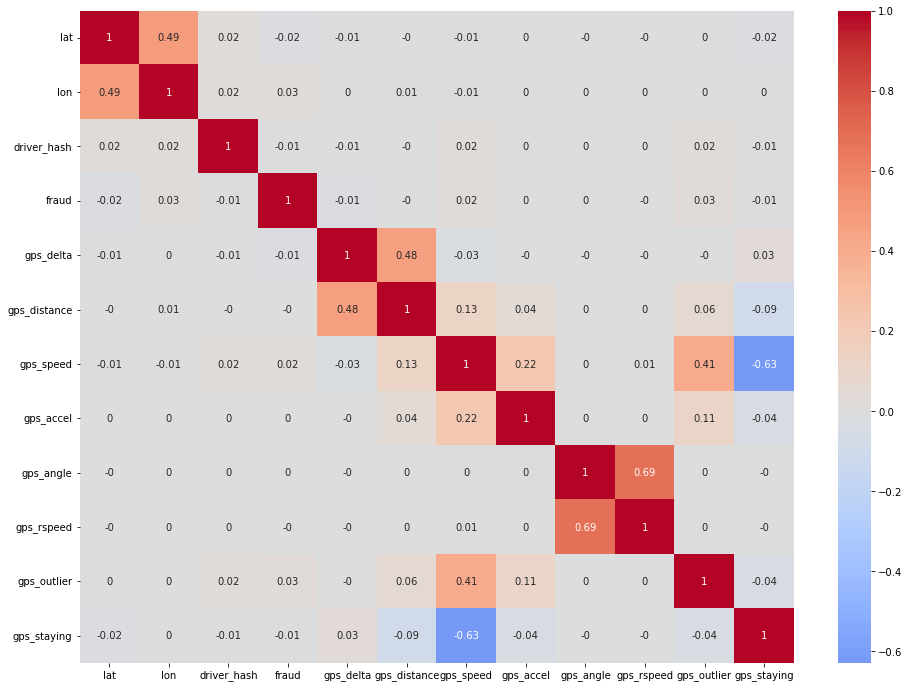

In [11]:
corr = df_gps.corr()

plt.figure(figsize=(16,12))
sns.heatmap(corr, cmap="coolwarm", annot=corr.round(2), center=0)
plt.show()

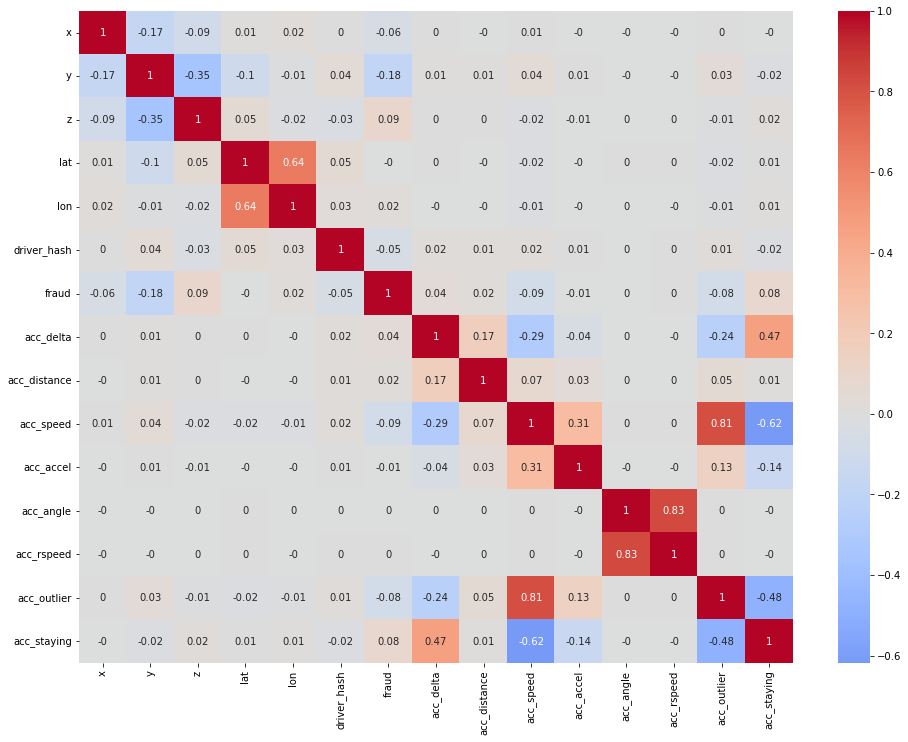

In [12]:
corr = df_accel.corr()

plt.figure(figsize=(16,12))
sns.heatmap(corr, cmap="coolwarm", annot=corr.round(2), center=0)
plt.show()